# Assignment: Analyzing Wikipedia Pages

In this assignment, you will analyze a small fraction of [Wikipedia](https://en.wikipedia.org/wiki/Main_Page) pages. For manipulating Wikipedia pages, you will use `pywikibot` module, which could require an installation. You can install the module in several ways; it depends on your installation of Python and Jupyter. If you have administrator rights, you can use
```
pip install pywikibot
```
You can call it directly from the notebook:

```
!pip install pywikibot
```
Official documentation for the `pywikibot` module can be found [here](https://doc.wikimedia.org/pywikibot/stable/).

In [1]:
import pywikibot as pw
import networkx as nx
from pprint import pprint
import numpy as np

Module `pywikibot` enables us to load Wikipedia pages and extract links contained within the pages. E.g., let us download the page about the beatle [Bembidion Ambiguum](https://en.wikipedia.org/wiki/Bembidion_ambiguum) 

![Bembidion ambiguum from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/Bembidion_ambiguum.jpg/193px-Bembidion_ambiguum.jpg)

Let us list all links from the page.

In [2]:
name = "Bembidion ambiguum"
page = pw.Page(pw.Site('en', 'wikipedia'), name)

linkedpages_list = []
for lp in page.linkedPages():
    linkedpages_list.append(lp.title())
    
print(f"The Wikipedia page on '{name}' has the title '{page.title()}' and contains {len(linkedpages_list)} links:")
print("\n".join(linkedpages_list))

The Wikipedia page on 'Bembidion ambiguum' has the title 'Bembidion ambiguum' and contains 27 links:
Animal
Arthropod
Beetle
Bembidion
Binomial nomenclature
California
Doi (identifier)
Eukaryote
Global Biodiversity Information Facility
Ground beetle
INaturalist
Insect
Mediterranean region
PMC (identifier)
PMID (identifier)
Pierre François Marie Auguste Dejean
Salt marsh
San Francisco Bay
Taxonomy (biology)
Trechinae
Wikidata
Wikispecies
Wikipedia:Stub
Template:Taxonomy/Bembidion
Template:Trechinae-stub
Template talk:Trechinae-stub
Help:Taxon identifiers


We can also extract pages that refer to the page "Bembidion ambiguum".

In [3]:
references_list = []
for item_reflink in page.getReferences():
    references_list.append(item_reflink.title())

print(f"There are {len(references_list)} pages linking to the page '{name}':")
print("\n".join(references_list))

There are 5 pages linking to the page 'Bembidion ambiguum':
List of Bembidion species
Talk:Bembidion ambiguum
Wikipedia:WikiProject Academic Journals/Journals cited by Wikipedia/B53
Bembidion ambiguum
Talk:Bembidion ambiguum


Our goal will be to analyze some notion that has a page in Wikipedia by building and analyzing the so-called ego network around the given notion.

At first, you should build the ego network, a subgraph of nodes close to the node representing the given notion. Then, you will analyze the network.

Your task is to implement three functions and then use them to analyze given notions.

The first function 
```
get_ego_network(ego)
```
should build a **directed** ego network around the page with the title `ego`. The ego network should contain all neighbors of the `ego` page and all links among them:
* the `ego` node,
* all nodes corresponding to Wikipedia pages referred to in the `ego` page, 
* all nodes corresponding to Wikipedia pages that refer to the `ego` page, and
* all (directed) edges between the nodes.

Hence, if a page from the ego network contains a link to a Wikipedia page not contained in the ego network, the link is ignored.

Your implementation should **omit** 
* pages with titles containing the suffix "(identifier)" or "(Identifier)",
* pages with titles containing the colon `:` (e.g., "Template:Taxonomy/Bembidion"),
* self-loops (e.g., "Bembidion ambiguum" in the pages referencing the page "'Bembidion ambiguum'").

In [4]:
def omit_title(title, source):
    if ':' in title:
        return True
    elif title == source:
        return True
    #check '(identifier)' and '(Identifier)' as suffixes
    elif title.endswith('(identifier)') or title.endswith('(Identifier)'):
        return True
    else:
        return False

def get_ego_network(ego):
    '''Create ego network - a directed graph of Wikipedia pages - around the 
    page with the title ego.
    '''
    ego_net = nx.DiGraph()
    ego_net.add_node(ego)
    ego_page = pw.Page(pw.Site('en', 'wikipedia'), ego)
    for lp in ego_page.linkedPages():
        if omit_title(lp.title(), ego):
            continue
        else:
            ego_net.add_edge(ego, lp.title())
    for rp in ego_page.getReferences():
        if omit_title(rp.title(), ego):
            continue
        else:
            ego_net.add_edge(rp.title(), ego)
    for node in ego_net.nodes():
        for lp in pw.Page(pw.Site('en', 'wikipedia'), node).linkedPages():
            if omit_title(lp.title(), node):
                continue
            else:
                if lp.title() in ego_net.nodes():
                    ego_net.add_edge(node, lp.title())
    return ego_net

The implementation of `get_ego_network` will be tested below, including some hidden tests (**1 point**).

In [5]:
ego = 'Bembidion ambiguum'
e = get_ego_network(ego)

print("Number of nodes", len(e))
print("Number of edges", len(list(e.edges())))
assert len(e) == 21
assert len(list(e.edges())) == 109


Number of nodes 21
Number of edges 109


Implement the function
```
get_network(name, download=False)
```

that should create the ego-network (directed network of type `nx.DiGraph()`) around the page with the title `name`. If `download` is `True`, the network should be built by downloading pages from Wikipedia, and the built network should be stored as an edge list in the file with the name 
```
name+'.csv'
```
If `download` is `False`, the function will check whether the file with the name `name+'.csv'` exists. If yes, it assumes that 
the file contains the edge-list of the ego network around the notion from the parameter `name`
and returns a network (`nx.DiGraph()`) with the network. Otherwise, it collects the network by calling
the function `get_ego_network(name)` and stores it in the corresponding CSV-file, and returns the network.

In [6]:
def get_network(name, download=False):
    '''Create the network around the Wikipedia page with the title name. 
    Parameters:
        Name (string)      the title of the page
        depth (int)        the depth of the collected ego network
        download (Boolean) if download is False and a file <name>.csv exists, the network 
                           is read from the file; otherwise, it is built using the function
                           get_wikipedia_network(name,depth) and saved into file <name>.csv
                           as a list of edges.
    Returns:
        An instance of nx.DiGraph() with the ego network around Wikipedia page name.
    '''
    if download:
        net = get_ego_network(name)
        nx.write_edgelist(net, name + ".csv", delimiter=':', data=False)
    else:
        try:
            net = nx.read_edgelist(name + ".csv", delimiter=':', create_using=nx.DiGraph())
        except FileNotFoundError:
            net = get_ego_network(name)
            nx.write_edgelist(net, name + ".csv", delimiter=':', data=False)
    return net


The implementation of `get_network` will be tested below, including some hidden tests (**1 point**).

In [7]:
ego = 'Bembidion ambiguum'



G_Ambiguum = get_network(ego, download=True)


Using the above functions (and possibly other suitable functions) implement the function

In [8]:
def analyze_ego(G, ego):
    '''Analyze the ego network G with the root node ego.
    '''
    all_nodes_except_ego = []
    for nodes in G.nodes():
        if nodes != ego:
            all_nodes_except_ego.append(nodes)
    G_without_ego = G.subgraph(all_nodes_except_ego)

    analyze_dict = {}
    analyze_dict['out_degree'] = G.out_degree(ego)
    analyze_dict['in_degree'] = G.in_degree(ego)
    analyze_dict['node_num'] = len(G.nodes())
    analyze_dict['edge_num'] = len(G_without_ego.edges())
    analyze_dict['density'] = nx.density(G)
    analyze_dict['density_without_ego'] = nx.density(G_without_ego)
    analyze_dict['betweenness'] = nx.betweenness_centrality(G,  normalized=True)[ego]
    analyze_dict['clustering_coefficient'] = (nx.clustering(G, ego))
    shortest_paths = []
    for node in G.nodes():
        if node != ego:
            for node2 in G.nodes():
                if node2 != ego and node != node2:
                    if nx.has_path(G, node, node2):
                        shortest_paths.append(nx.shortest_path_length(G, node, node2))
                    else:
                        shortest_paths.append(float('inf'))
    analyze_dict['avg_distance'] =  (sum(shortest_paths) / len(shortest_paths)) if len(shortest_paths) else 0
    analyze_dict['diameter'] = nx.diameter(G) if nx.is_strongly_connected(G) else float('inf')
    analyze_dict['weak_component_num'] = nx.number_weakly_connected_components(G_without_ego)
    analyze_dict['strong_component_num'] = nx.number_strongly_connected_components(G)
    brokerage = 0
    pairs = 0
    for node in G.nodes():
        if node != ego:
            for node2 in G.nodes():
                if node2 != ego and node != node2:
                    if nx.has_path(G, node, node2):
                        pairs += 1
                        if not nx.has_path(G_without_ego, node, node2):
                            brokerage += 1
    analyze_dict['brokerage'] = brokerage
    analyze_dict['avg_brokerage'] = brokerage/pairs

    return analyze_dict


that takes the ego network `G` around node `ego`, i.e., all nodes directly reachable from `ego` and the `ego` node itself. The function creates a dictionary containing values with the following keys:
* `out_degree`: the out-degree of the ego node,
* `in_degree`: the in-degree of the ego node (in the ego network only),
* `node_num`: the number of nodes in the ego network (including the ego),
* `edge_num`: the number of edges between the neighbors of the ego (without edges from or to the ego),
* `density`: the ratio of the number of edges in the whole ego network (including the ego node) and the maximal possible number of edges in the whole ego network,
* `density_without_ego`: the ratio of the number of edges in the ego network without the ego and the maximal possible number of edges in the ego network without the ego,
* `betweenness`: the value of the normalized betweenness centrality for the `ego` node,
* `clustering coefficient`: the fraction of all possible directed triangles \(\frac{T(\texttt{ego})}{2(deg(\texttt{ego})(deg(\texttt{ego})-1) - 2deg^{\leftrightarrow}(\texttt{ego}))}\), where \(T(\texttt{ego})\) is the number of directed triangles through the node ego, \(deg(\texttt{ego})\) is the sum of in-degree and out-degree of ego, and \(deg^{\leftrightarrow}(\texttt{ego})\) is the number nodes \(v\) such that the network contains both edges (ego,\(v\)) and (\(v\),ego)
* `avg_distance`: the mean of the shortest path lengths among all pairs of the neighbors of the ego (paths in the whole ego network); if there are two nodes between which there is no oriented path in the network, the resulting value should be `float('inf')`,
* `diameter`: diameter of the ego network; if there are two nodes between which there is no oriented path in the network, the resulting value should be `float('inf')`,
* `weak_component_num`: the number of weak components in the network without the ego node; a weak component is the largest number of nodes that are connected, disregarding the direction of the edges (a strong component pays attention to the direction of the edges for directed data); if ego was connected to $A$ and $B$ (which are connected to one another), and ego is connected to $C$ and $D$ (which also are connected to one another), but $A$ and $B$ are not connected in any way to $C$ and $D$ (except by way of everyone being connected to ego) then there would be two "weak components" in ego's neighborhood. 
* `strong_component_num`: the number of strong components; a strong component is the largest number of nodes that are mutually connected (directed paths are considered). 
* `brokerage`: the number of pairs connected with a directed path when the ego node is present and not connected when the ego node is missing. The ego is a broker if it is "between" a pair of nodes that, without the ego, would not be connected.
* `avg_brokerage`: the normalized brokerage (brokerage divided by the number of pairs); it assesses the extent to which ego's role is that of the broker. 

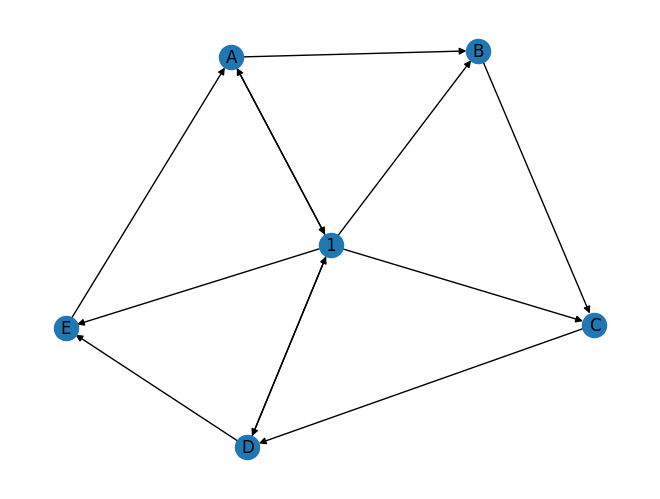

In [9]:
e1 = nx.DiGraph()
e1.add_edges_from([('1','A'), ('1','B'), ('1','C'), ('1','D'), ('1','E'),
                   ('A','1'), ('A','B'),  
                   ('B','C'),
                   ('C','D'),
                   ('D','1'), ('D','E'),
                   ('E','A')])
pos = nx.spring_layout(e1, seed=42)
nx.draw(e1, pos=pos, with_labels=True)

In [10]:
a = analyze_ego(e1, '1')
pprint(a)

from math import isclose

assert a['out_degree'] == 5
assert a['in_degree'] == 2
assert a['node_num'] == 6
assert a['edge_num'] == 5
assert a['density'] == 0.4 
assert a['density_without_ego'] == 0.25 
assert isclose(a['clustering_coefficient'], 0.2368421052631)
assert isclose(a['betweenness'], 0.425) 
assert isclose(a['avg_distance'], 2.1) 
assert isclose(a['diameter'], 4) 
assert a['weak_component_num'], 1 
assert a['strong_component_num'], 1 
assert a['brokerage'] == 0 
assert a['avg_brokerage'] == 0

{'avg_brokerage': 0.0,
 'avg_distance': 2.1,
 'betweenness': 0.42500000000000004,
 'brokerage': 0,
 'clustering_coefficient': 0.23684210526315788,
 'density': 0.4,
 'density_without_ego': 0.25,
 'diameter': 4,
 'edge_num': 5,
 'in_degree': 2,
 'node_num': 6,
 'out_degree': 5,
 'strong_component_num': 1,
 'weak_component_num': 1}


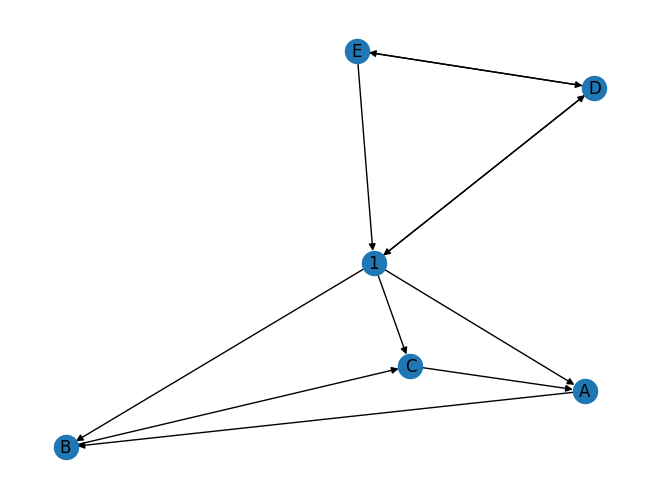

In [11]:
e2 = nx.DiGraph()
e2.add_edges_from([('1','A'), ('1','B'), ('1','C'), ('1','D'),
                   ('A','B'),  
                   ('B','C'),
                   ('C','A'),
                   ('D','1'), ('D','E'),
                   ('E','D'), ('E','1')])
pos = nx.spring_layout(e2, seed=42)
nx.draw(e2, pos=pos, with_labels=True)

In the folowing cell your implementation of the function `analyze_ego` will be tested on the ego network `e2` (**2 points**). 

In [12]:
a = analyze_ego(e2, '1')
pprint(a)


{'avg_brokerage': 0.42857142857142855,
 'avg_distance': inf,
 'betweenness': 0.30000000000000004,
 'brokerage': 6,
 'clustering_coefficient': 0.25,
 'density': 0.36666666666666664,
 'density_without_ego': 0.25,
 'diameter': inf,
 'edge_num': 3,
 'in_degree': 2,
 'node_num': 6,
 'out_degree': 4,
 'strong_component_num': 2,
 'weak_component_num': 2}


After that, you should use your functions and analyze four ego networks:
1. around `Network science`,
2. around `Social network`,
3. around `Social network analysis` and 
4. around your personal favorite Wikipedia page.

In the folowing cell you should analyze ego network around `Bembidion ambiguum` (**1 point**). 

In [13]:
ego = 'Bembidion ambiguum'
G_Ambiguum = get_network(ego, download=True)

results = analyze_ego(G_Ambiguum, ego)
pprint(results)

from math import isclose
assert isclose(results["out_degree"], 19, abs_tol=1)
assert isclose(results["in_degree"], 1, abs_tol=1)
assert isclose(results["node_num"], 21, abs_tol=1)
assert isclose(results["edge_num"], 87, abs_tol=3)
assert isclose(results["density"], 0.25952380952380955, rel_tol=0.01)
assert isclose(results["density_without_ego"], 0.23421052631578948, rel_tol=0.01)
assert isclose(results["clustering_coefficient"], 0.23421052631578948, rel_tol=0.01)


{'avg_brokerage': 0.04819277108433735,
 'avg_distance': inf,
 'betweenness': 0.043421052631578944,
 'brokerage': 8,
 'clustering_coefficient': 0.23421052631578948,
 'density': 0.25952380952380955,
 'density_without_ego': 0.23421052631578948,
 'diameter': inf,
 'edge_num': 87,
 'in_degree': 1,
 'node_num': 21,
 'out_degree': 19,
 'strong_component_num': 9,
 'weak_component_num': 3}


In the folowing cell you should analyze ego network around `Network science` (**1 point**). 

In [14]:
ego = 'Network science'
G_N_science = get_network(ego, download=False)

res_dict = {}
res_dict[ego] = analyze_ego(G_N_science, ego)
pprint(res_dict[ego])


{'avg_brokerage': 0.08437025599771639,
 'avg_distance': inf,
 'betweenness': 0.33082738336309775,
 'brokerage': 26010,
 'clustering_coefficient': 0.06648053847937135,
 'density': 0.048890736492033085,
 'density_without_ego': 0.04718086791257523,
 'diameter': inf,
 'edge_num': 14122,
 'in_degree': 276,
 'node_num': 617,
 'out_degree': 432,
 'strong_component_num': 120,
 'weak_component_num': 24}


In the folowing cell you should analyze ego network around `Social network` (**1 point**). 

In [15]:
ego = 'Social network'
G_S_network = get_network(ego, download=False)

res_dict[ego] = analyze_ego(G_S_network, ego)
pprint(res_dict[ego])


{'avg_brokerage': 0.11402386558675234,
 'avg_distance': inf,
 'betweenness': 0.37887979842848785,
 'brokerage': 503040,
 'clustering_coefficient': 0.028210520168928308,
 'density': 0.014522780529291653,
 'density_without_ego': 0.014117961361226157,
 'diameter': inf,
 'edge_num': 78573,
 'in_degree': 2290,
 'node_num': 2717,
 'out_degree': 774,
 'strong_component_num': 1067,
 'weak_component_num': 242}


In the folowing cell you should analyze ego network around `Social network analysis` (**1 point**). 

In [16]:
ego = 'Social network analysis'
G_S_N_Analysis = get_network(ego, download=False)

res_dict[ego] = analyze_ego(G_S_N_Analysis, ego)
pprint(res_dict[ego])


{'avg_brokerage': 0.06158717601496643,
 'avg_distance': inf,
 'betweenness': 0.3377704124541689,
 'brokerage': 30517,
 'clustering_coefficient': 0.1151784658070483,
 'density': 0.07849310222851079,
 'density_without_ego': 0.07706753584516914,
 'diameter': inf,
 'edge_num': 24051,
 'in_degree': 543,
 'node_num': 771,
 'out_degree': 422,
 'strong_component_num': 125,
 'weak_component_num': 27}


In the folowing two cells you should select your favourite Wikipedia page and analyze its ego network (**1 point**). 

In [20]:
ego = 'Kylian Mbappé'

G_favorite = get_network(ego, download=False)

res_dict[ego] = analyze_ego(G_favorite, ego)
pprint(res_dict[ego])

{'avg_brokerage': 0.01591808564978184,
 'avg_distance': inf,
 'betweenness': 0.20962237676352025,
 'brokerage': 20412,
 'clustering_coefficient': 0.07450573108481452,
 'density': 0.06531719899989435,
 'density_without_ego': 0.06427690593670125,
 'diameter': inf,
 'edge_num': 59884,
 'in_degree': 807,
 'node_num': 1168,
 'out_degree': 761,
 'strong_component_num': 64,
 'weak_component_num': 7}


In [18]:
assert res_dict[ego]['node_num'] > 1

Collect the obtained measures in a table.

In [19]:
# create a table: rows should be collected measures, and columns should be titles of the ego nodes
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
df = pd.DataFrame(res_dict)
df

,Network science,Social network,Social network analysis,Kylian Mbappé
out_degree,432.00,774.00,422.00,761.00
in_degree,276.00,2290.00,543.00,807.00
node_num,617.00,2717.00,771.00,1168.00
edge_num,14122.00,78573.00,24051.00,59884.00
density,0.05,0.01,0.08,0.07
density_without_ego,0.05,0.01,0.08,0.06
betweenness,0.33,0.38,0.34,0.21
clustering_coefficient,0.07,0.03,0.12,0.07
avg_distance,inf,inf,inf,inf
diameter,inf,inf,inf,inf


Are the networks comparable? Compare the four ego networks according to the obtained results and write yoyr answer in the cell below (**1 point**).

We can clearly see that the biggest network is the Social Network one, followed by Mbappé and then Network Science and Social Network Analysis. This seems pretty logical as Social Science and Social Network Analysis seems to be subtopics of Social Networks in general.

Then, we can see that the biggest edge_number / node_number ratio is for the Mbappé one, which suggest that every linked pages (footballers and teams for example) have more interactions between each others. The others have smaller values probably because it is easier to bifurcate on totally different subsubjects.

However, the betweeness is higher in the scientifics network, probably because they are important fields used in many others. Where Mbappé is for example just part of the france team as every other french players so if he was there or not he wouldn't change anything for a lot of actors linked through the france team. The brokerage value kind of follows these, which seems logical except for the SNA network which could be because of various other longer path but existing ones between the different nodes of the network.

There is very few clustering values in all of these networks, except for the social network analysis, maybe because it leads to very specific applications.

Every scientific networks have similar weak and strong components numbers whereas the Mbappé one is particularly low : which is clearly in adequation with what we saw earlier.

Finally the fact that the only network with density dropping while removing ego node is the Mbappé one, that indicates that it is an important node in the network (which is in adequation with the real life as Mbappé is a major actor of the football world).







## What to submit

1. Notebook, where all the questions are answered, and the requested code is filled in.
2. Five CSV files with downloaded networks
3. 1. `Bembidion ambiguum.csv`,
   2. `Network science.csv`
   3. `Network science.csv`
   4. `Social network analysis.csv`
   5. CSV file with the ego network of your favorite Wikipedia page.